The purpose of this notebook is to extract additional Rrs data by using highly correlated channels adjacent to the bands of interest; in this case SeaWiFS bands.

In [28]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
from seaborn import heatmap
from cmocean import cm
from sklearn.linear_model import LinearRegression as LR

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [11]:
% matplotlib inline
pl.style.use('tableau-colorblind10')
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.labelsize'] = 16
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 16

In [29]:
def pairwise_fill(row, feature_1, feature_2):
    """simple pairwise imputation"""
    if np.isnan(row[feature_1]):
        return row[feature_2]
    else:
        return row[feature_1]

In [3]:
with open('./pickleJar/NOMAD_AOP&IOPs.pkl', 'rb') as f:
    d_dict = pickle.load(f)
    d_aop = d_dict['d_aop']

In [4]:
del d_dict
d_aop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 38 columns):
id              4459 non-null object
datetime        4459 non-null datetime64[ns]
doy             4459 non-null float64
lat             4459 non-null float64
lon             4459 non-null float64
etopo2          4459 non-null float64
bathymetry      4459 non-null float64
oisst           4459 non-null float64
wtemp           1235 non-null float64
woa_sst_mean    2516 non-null float64
woa_sst_se      2516 non-null float64
sal             672 non-null float64
woa_sal_mean    2511 non-null float64
woa_sal_se      2511 non-null float64
rrs405          12 non-null float64
rrs411          4293 non-null float64
rrs443          4456 non-null float64
rrs455          393 non-null float64
rrs465          375 non-null float64
rrs489          4422 non-null float64
rrs510          3435 non-null float64
rrs520          1559 non-null float64
rrs530          1589 non-null float64
rrs550          91

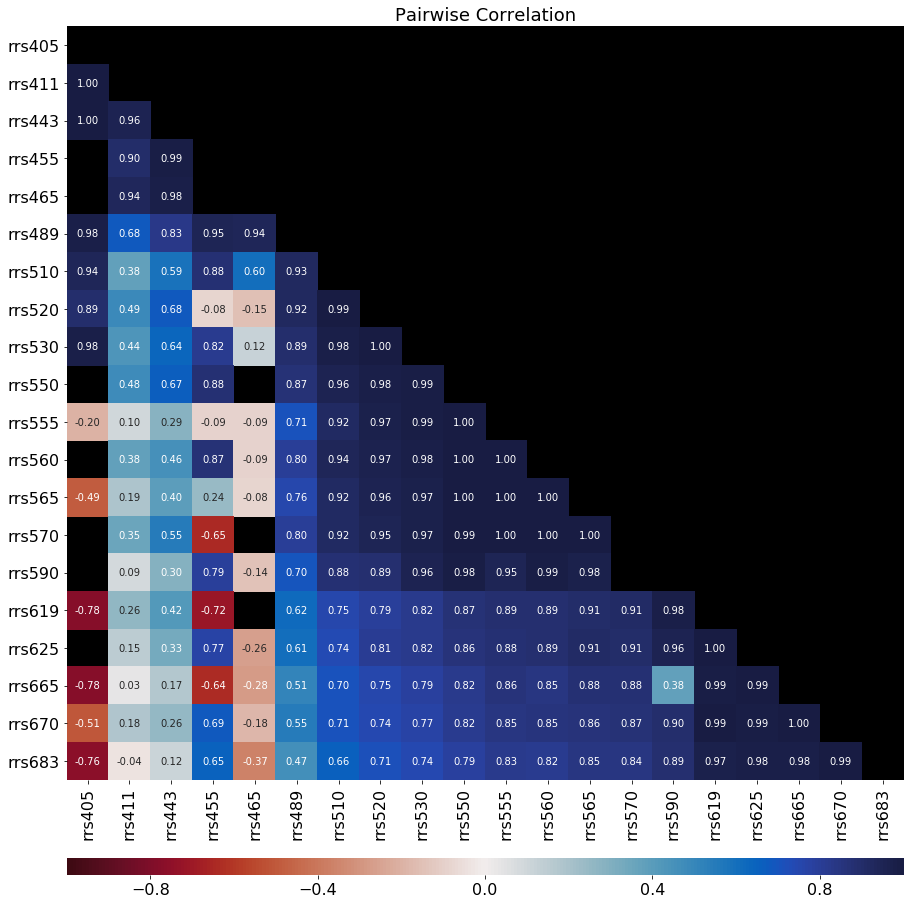

In [20]:
f, ax = pl.subplots(figsize=(15, 18))
ax.set_facecolor('k')
cols=[col for col in d_aop.columns if 'rrs' in col]
heatmap(d_aop[cols].corr(), cmap=cm.balance_r, annot=True, vmin=-1, vmax=1,
           mask=np.triu(np.ones([len(cols)]*2)), ax=ax, fmt='.2f',
          cbar_kws={'aspect': 50, 'orientation': 'horizontal', 'pad': 0.08});
ax.set_title('Pairwise Correlation')
f.savefig('./figJar/impute_1_pw_corr.png', dpi=300, format='png')

The heatmap above shows pairwise correlation between bands; the data shown is each cells indicates the Pearson correlation between crossing row/column pairs. This suggests that there is potential for missing data imputation for SeaWiFS blue (443, 489, 510), green (555), and red (670) bands. I'll explore this next. I'll start with blue bands.

### <u>Blues</u>

In [25]:
blues = ['rrs405', 'rrs411', 'rrs443' ,'rrs455', 'rrs465', 'rrs489', 'rrs510', 'rrs520']
d_aop[blues].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 8 columns):
rrs405    12 non-null float64
rrs411    4293 non-null float64
rrs443    4456 non-null float64
rrs455    393 non-null float64
rrs465    375 non-null float64
rrs489    4422 non-null float64
rrs510    3435 non-null float64
rrs520    1559 non-null float64
dtypes: float64(8)
memory usage: 278.8 KB


There are too few Rrs405 observations available to attempt to establish a robust relationship with respect to other bands. 405 will no longer be considered.

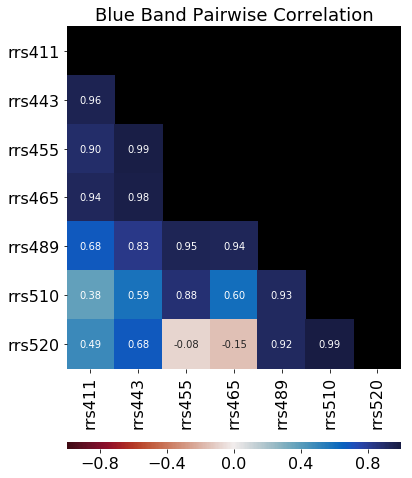

In [26]:
blues = ['rrs411', 'rrs443' ,'rrs455', 'rrs465', 'rrs489', 'rrs510', 'rrs520']
f, ax = pl.subplots(figsize=(6,9))
ax.set_facecolor('k')
ax.set_title('Blue Band Pairwise Correlation')
heatmap(d_aop[blues].corr(), cmap=cm.balance_r, annot=True, vmin=-1, vmax=1,
           mask=np.triu(np.ones([len(blues)]*2)), ax=ax, fmt='.2f',
          cbar_kws={'aspect': 50, 'orientation': 'horizontal'});
f.savefig('./figJar/impute2_pwcorr_blues.png', dpi=300, format='png')

The above suggests 455 and 465 should be examined further as as source of imputation for 443, similarly 520 is a candidate for imputing 510 values.

In [21]:
d_blues = d_aop[blues]

In [22]:
d_blues.loc[(d_blues.rrs443.isnull()) & (~d_blues.rrs455.isnull())].shape

(0, 8)

In [23]:
d_blues.loc[(d_blues.rrs443.isnull()) & (~d_blues.rrs455.isnull())].shape

(0, 8)

Unfortunately there are no observations where 443 is not available and any of 455 and 465 are. Looking at 510 & 520:

In [27]:
d_blues.loc[(d_blues.rrs510.isnull()) & (~d_blues.rrs520.isnull())].shape

(772, 8)

Here there are a fair number of 520 observations where 510 are missing. I'll examine the relationship between 510 and 520 in more detail by comparing an imputation by simple replacement and by linear regression:

In [38]:
d_blues_510_520 = d_blues[['rrs510', 'rrs520']]

In [50]:
xy_510_520_train = d_blues_510_520.dropna().as_matrix()
x_520_to_fit = d_blues_510_520.loc[(d_blues_510_520.rrs510.isnull()) &
                                  (~d_blues_510_520.rrs520.isnull()),
                                   'rrs520'].values.reshape(-1, 1)

In [47]:
y_510_train = xy_510_520_train[:, 0].reshape(-1, 1)
x_520_train = xy_510_520_train[:, 1].reshape(-1, 1)

In [37]:
lr510 = LR()

In [48]:
lr510.fit(x_520_train, y_510_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [51]:
y_510_predict = lr510.predict(x_520_to_fit)

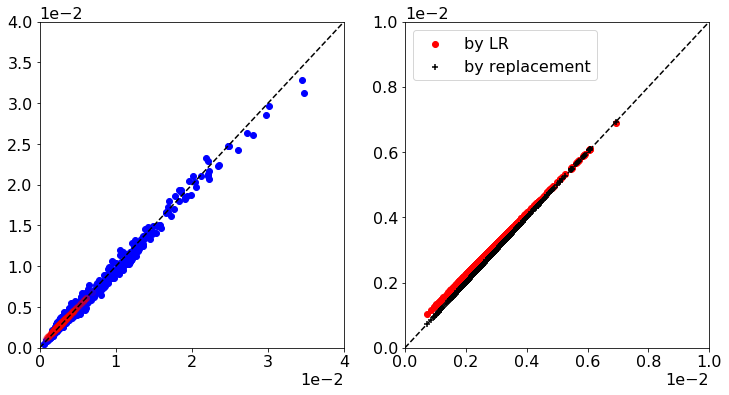

In [75]:
max_impute_rrs520 = d_blues.loc[(d_blues.rrs510.isnull()) & (~d_blues.rrs520.isnull()),
                                'rrs520']
lims = [0, 4e-2]
lims2 = [0, 1e-2]
f, axs = pl.subplots(ncols=2, figsize=(12,6))
axs[0].plot(lims, lims, 'k--')
axs[0].set_xlim(lims)
axs[0].set_ylim(lims)
axs[0].scatter(x_520_train, y_510_train, marker='o', color='b')
axs[0].scatter(x_520_to_fit, y_510_predict, marker='o', color='r', alpha=0.1);
axs[1].plot(lims2, lims2, 'k--')
axs[1].set_xlim(lims2)
axs[1].set_ylim(lims2)
axs[1].scatter(x_520_to_fit, y_510_predict, marker='o', color='r', label='by LR');
axs[1].scatter(x_520_to_fit, x_520_to_fit, marker='+', color='k', label='by replacement');
axs[1].legend()
#ax.axvline(0.007)

So there appear to be a slight deviation with the regression line. However, that the observations to be imputed occur in the low range where the 1-1 relationship is relatively close. Therefore, I 'll  use the pairwise_fill function, defined above to impute by replacement.

In [61]:
d_blues_510_520['510_i'] = d_blues_510_520.apply(pairwise_fill,
                                                 axis=1, args=('rrs510', 'rrs520'))

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [62]:
d_blues_510_520.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 3 columns):
rrs510    3435 non-null float64
rrs520    1559 non-null float64
510_i     4207 non-null float64
dtypes: float64(3)
memory usage: 104.6 KB


### <u>Green</u>

Here, I describe the imputation of missing Rrs(555) data from adjacent bands, including 550, 560, 565, 570.

In [64]:
greens = ['rrs550', 'rrs555', 'rrs560', 'rrs565', 'rrs570']
d_greens = d_aop[['id'] + greens]
d_greens.insert(d_greens.shape[1], '555_i', np.NaN)
d_greens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 7 columns):
id        4459 non-null object
rrs550    912 non-null float64
rrs555    3255 non-null float64
rrs560    1193 non-null float64
rrs565    1884 non-null float64
rrs570    816 non-null float64
555_i     0 non-null float64
dtypes: float64(6), object(1)
memory usage: 243.9+ KB


Examining the pairwise relationship suggests an imputation by direct replacement is reasonable:

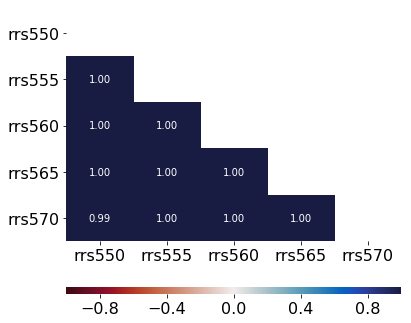

In [70]:
_, ax = pl.subplots(figsize=(6,6))
heatmap(d_aop[greens].corr(), cmap=cm.balance_r, annot=True, vmin=-1, vmax=1,
           mask=np.triu(np.ones([len(greens)]*2)), ax=ax, fmt='.2f',
          cbar_kws={'aspect': 50, 'orientation': 'horizontal', 'pad': 0.14});

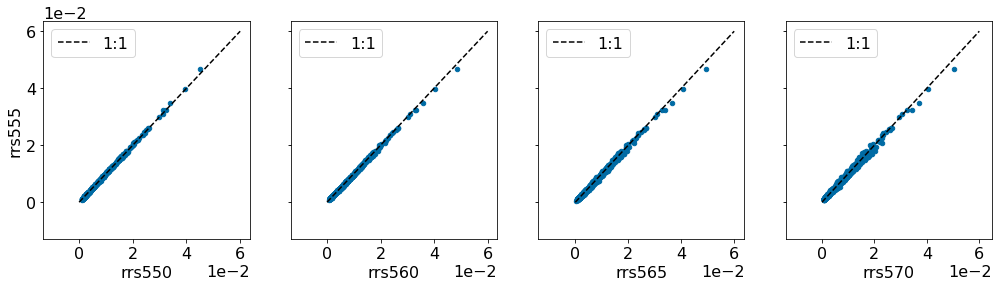

In [80]:
greens.remove('rrs555')
lr = len(greens)
f, axs = pl.subplots(ncols=lr, figsize=(4*lr+1, lr), sharey=True)
for ax, gr in zip(axs.ravel(), greens):
    
    d_greens[[gr, 'rrs555']].dropna().plot(x=gr, y='rrs555', kind='scatter', ax=ax)
    ax.plot([0, 6e-2], [0, 6e-2], 'k--', label='1:1')
    ax.legend()

Imputation would increase the number of observations from 3255 to...

In [73]:
d_greens[(~d_greens.rrs550.isnull())|(~d_greens.rrs555.isnull()) |
         (~d_greens.rrs560.isnull())|(~d_greens.rrs565.isnull()) |
         (~d_greens.rrs570.isnull())].shape[0]

4453

or an increase of almost 1200 observations! Next then is the pairwise imputation:

In [ ]:
d_greens.info()

In [84]:
# pairwise imputation
print(f"starting from {d_greens.rrs555.isnull().sum()}")
d_greens['555_i'] = d_greens.rrs555
for gr in greens:
    print(f'Imputing from {gr}...')
    d_greens['555_i'] = d_greens.apply(pairwise_fill, axis=1, args=(gr, '555_i'))
    print('Number of nulls left in 555: %d' % d_greens['555_i'].isnull().sum() )

starting from 1204
Imputing from rrs550...
Number of nulls left in 555: 908
Imputing from rrs560...


/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Number of nulls left in 555: 769
Imputing from rrs565...
Number of nulls left in 555: 6
Imputing from rrs570...
Number of nulls left in 555: 6


In [86]:
d_greens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 7 columns):
id        4459 non-null object
rrs550    912 non-null float64
rrs555    3255 non-null float64
rrs560    1193 non-null float64
rrs565    1884 non-null float64
rrs570    816 non-null float64
555_i     4453 non-null float64
dtypes: float64(6), object(1)
memory usage: 243.9+ KB


### <u>Red</u>

The closest bands are 619, 625, 665, and 683. Examining pairwise relationship shows that:

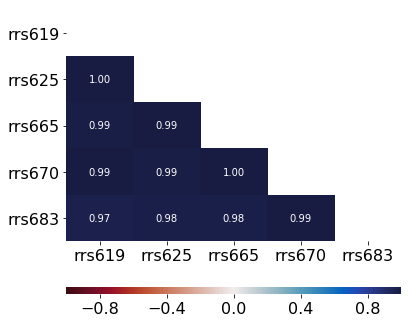

In [89]:
d_reds = d_aop[['id', 'rrs619', 'rrs625', 'rrs665', 'rrs670', 'rrs683']]
d_reds.insert(d_reds.shape[1], '670_i', np.NaN)
_, ax= pl.subplots(figsize=(6,6))
red_cols = ['rrs619', 'rrs625', 'rrs665', 'rrs670', 'rrs683']
heatmap(d_reds[red_cols].corr(), cmap=cm.balance_r, annot=True, vmin=-1, vmax=1,
           mask=np.triu(np.ones([len(red_cols)]*2)), ax=ax, fmt='.2f',
          cbar_kws={'aspect': 50, 'orientation': 'horizontal', 'pad': 0.14});

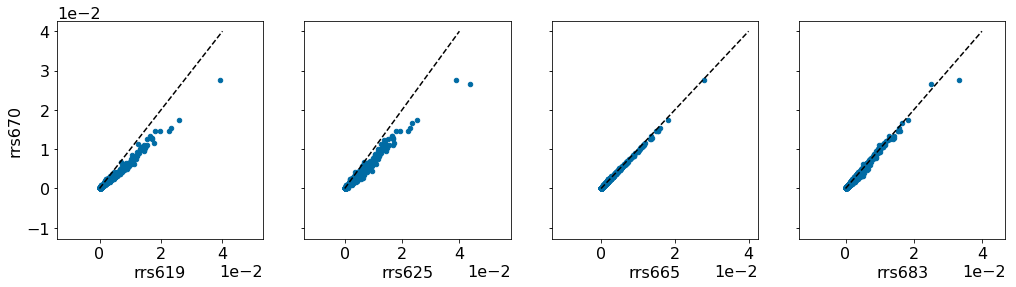

In [100]:
reds_ = ['rrs619', 'rrs625', 'rrs665', 'rrs683']
lr = len(reds_)
f, axs = pl.subplots(ncols=lr, figsize=(4*lr+1, lr), sharey=True)
for ax, red in zip(axs.ravel(), reds_):
    d_reds[[red, 'rrs670']].dropna().plot(x=red, y='rrs670', kind='scatter', ax=ax)
    ax.plot([0, 4e-2], [0, 4e-2], 'k--')

Examining the number of observations from imputation:

In [91]:
d_reds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 7 columns):
id        4459 non-null object
rrs619    883 non-null float64
rrs625    1884 non-null float64
rrs665    2641 non-null float64
rrs670    1598 non-null float64
rrs683    2008 non-null float64
670_i     0 non-null float64
dtypes: float64(6), object(1)
memory usage: 243.9+ KB


In [92]:
d_reds[(~d_reds.rrs665.isnull()|~d_reds.rrs670.isnull())].shape[0]

3357

In [95]:
d_reds[((~d_reds.rrs665.isnull())|(~d_reds.rrs670.isnull())|
       (~d_reds.rrs683.isnull()))].shape[0]

3365

In [98]:
d_reds[((~d_reds.rrs665.isnull())|(~d_reds.rrs670.isnull())|
       (~d_reds.rrs625.isnull()))].shape[0]

3897

In [97]:
d_reds[((~d_reds.rrs665.isnull())|(~d_reds.rrs670.isnull())|
       (~d_reds.rrs625.isnull())|(~d_reds.rrs619.isnull()))].shape[0]

3897

In [99]:
d_reds[((~d_reds.rrs665.isnull())|(~d_reds.rrs670.isnull())|
       (~d_reds.rrs625.isnull())|(~d_reds.rrs683.isnull()))].shape[0]

3905

Imputation from Rrs619 would not increase the data count. Imputation by replacement appears reasonable for 665 and 683. I will then impute data from 625 via simple linear regression.

In [101]:
#d_reds['670_i'] = d_reds['rrs670']
d_reds['670_i'] = d_reds.apply(pairwise_fill, axis=1, args=('rrs670', 'rrs665'))
d_reds['670_i'] = d_reds.apply(pairwise_fill, axis=1, args=('670_i', 'rrs683'))

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Imputing from 625 via linear regression:

In [104]:
lr = LR()
xy_train = d_reds[['rrs625', 'rrs670']].dropna().as_matrix()
lr.fit(xy_train[:, 0].reshape(-1, 1), xy_train[:, 1])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [109]:
x_predict = d_reds.loc[~d_reds.rrs625.isnull() & d_reds['670_i'].isnull(), 'rrs625'].values

In [110]:
x_predict.shape

(540,)

In [111]:
y_predict = lr.predict(x_predict.reshape(-1, 1))

In [112]:
d_reds.loc[~d_reds.rrs625.isnull() & d_reds['670_i'].isnull(), '670_i'] = y_predict

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [113]:
d_reds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 7 columns):
id        4459 non-null object
rrs619    883 non-null float64
rrs625    1884 non-null float64
rrs665    2641 non-null float64
rrs670    1598 non-null float64
rrs683    2008 non-null float64
670_i     3905 non-null float64
dtypes: float64(6), object(1)
memory usage: 243.9+ KB


In [ ]:
%matplotlib inline
_, ax= pl.subplots(figsize=(6,6))
red_cols = ['rrs619', 'rrs625', 'rrs665', 'rrs670', 'rrs683']
heatmap(d_reds[red_cols].corr(), cmap=cm.balance_r, annot=True, vmin=-1, vmax=1,
           mask=np.triu(np.ones([len(red_cols)]*2)), ax=ax, fmt='.2f',
          cbar_kws={'aspect': 50, 'orientation': 'horizontal', 'pad': 0.14});

In [114]:
smpl_cols1 = ['id', 'datetime', 'doy', 'lat', 'lon', 'etopo2',
             'oisst', 'wtemp', 'woa_sst_mean', 'woa_sst_se',
             'sal', 'woa_sal_mean', 'woa_sal_se']
smpl_cols2 = ['rrs411', 'rrs443', 'rrs489', 'rrs510', 'rrs555','rrs670']
smpl_cols3 = ['fluo_chl', 'hplc_chl', 'is_hplc', 'chl']
d_aop_2 = pd.DataFrame(columns=smpl_cols1 + smpl_cols2 + smpl_cols3)
d_aop_2[smpl_cols1] = d_aop[smpl_cols1]
d_aop_2[['rrs411', 'rrs443', 'rrs489']] = d_aop[['rrs411', 'rrs443', 'rrs489']]
d_aop_2['rrs510'] = d_blues_510_520['510_i']
d_aop_2['rrs555'] = d_greens['555_i']
d_aop_2['rrs670'] = d_reds['670_i']
d_aop_2[smpl_cols3] = d_aop[smpl_cols3]
d_aop_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 23 columns):
id              4459 non-null object
datetime        4459 non-null datetime64[ns]
doy             4459 non-null float64
lat             4459 non-null float64
lon             4459 non-null float64
etopo2          4459 non-null float64
oisst           4459 non-null float64
wtemp           1235 non-null float64
woa_sst_mean    2516 non-null float64
woa_sst_se      2516 non-null float64
sal             672 non-null float64
woa_sal_mean    2511 non-null float64
woa_sal_se      2511 non-null float64
rrs411          4293 non-null float64
rrs443          4456 non-null float64
rrs489          4422 non-null float64
rrs510          4207 non-null float64
rrs555          4453 non-null float64
rrs670          3905 non-null float64
fluo_chl        3392 non-null float64
hplc_chl        1381 non-null float64
is_hplc         4459 non-null bool
chl             4127 non-null float64
dtypes: bool(1), 

In [ ]:
d_aop_2.to_pickle('./pickleJar/dfNomad_AOP.pkl')